In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
# use SVG as backend
%config InlineBackend.figure_format = 'svg'

import simpy as sim
import collections
import random
import statistics
import math
import numpy as np
import pandas as pd
from scipy.stats import poisson

import tqdm

In [3]:
def customer(env, drink, num_stocks, vendor):
    """customer wait in line to buy either "Ice cream" or "Hot chocolate",
    when it's turn, approach the truck (vendor) and 
    buy ice cream, assume each customer 1 drink at a time 
    (num_stocks).
     When  STOCK sold_out, customer leaves line. 
    """
    #global cnt
    with vendor.counter.request() as my_turn:
        # Wait until its your turn or until the STOCK is sold out
        result = yield my_turn | vendor.sold_out[drink]
        # Check if it's our turn or if drink is sold out
        if my_turn not in result:
            vendor.num_AfterSoldout[drink] += 1
            return

        # Check if enough drink left.
        if vendor.available[drink] < num_stocks:
            # Customer leaves immediately
            yield env.timeout(0)
            return

        # Buy drink
        vendor.available[drink] -= num_stocks
        if vendor.available[drink] < 2:
            # Trigger the "sold out" event for the drink
            vendor.sold_out[drink].succeed()
            vendor.when_sold_out[drink] = env.now
            vendor.available[drink] = 0
        yield env.timeout(1)
        


SIM_TIME = 300 
def customer_arrivals(env, vendor):
    
    A = (Tmin - Tmax)/2
    C = (Tmax + Tmin)/2
    ω = math.pi/12 # Angular frequency iof period (24hrs)
    D = 7 # Horizontal reflection
    t =  env.now
    while True:
        t =  env.now
        def f(t):
            temp = A*math.cos(ω*(t/60 - D)) + C 
            return temp
        ## temp = 57  ==> demand = 1 per hour 
        ## temp = 91  ==> demand = 200 per hour 
        def MapTempToDemand(Temp):
            t1,d1 = 57,1
            t2,d2 = 91,200
            return (d2 - d1)/(t2 - t1) * (Temp - t1) + d1
        def Dem(t):
            Temp = f(t) 
            return max(0.1,MapTempToDemand(Temp))

        Mean_Interarrival =  60/Dem(t)
        time_to_next_arrival = np.random.exponential(Mean_Interarrival) 

        yield env.timeout(time_to_next_arrival)

        drink = random.choice(vendor.Goods)  
        num_stocks = 1 #{"Ice cream" : 1, "Hot chocolate" : 1} #1       
        Product_Demands[drink] += num_stocks
        if vendor.available[drink]:
            env.process(customer(env, drink, num_stocks, vendor))

c_I = 2 # Cost price of Ice cream
c_H = 1 # Cost price of Hot chocolate
p = 3 # Sales price
s_I = 0.5 # storage cost for Ice cream
s_H = 0.01 # storage cost for Hot chocolate

              
def ICE_SIM(STOCK):
    
    global Product_Demands, Tmin, Tmax
    #Setup and start simulation
    env = sim.Environment()
    SIM_TIME = 300  # Simulate for 5hrs
    Tmax = np.random.randint(65,83)
    Tmin = np.random.randint(41,60)
    Product_Demands = {"Tmin" : Tmin, "Tmax" : Tmax, "Ice cream": 0, "Hot chocolate": 0 }


    # Create Ice cream Truck
    counter = sim.Resource(env, capacity=1)
    Goods = ["Ice cream", "Hot chocolate"] # 
    available = {drink: STOCK for drink in Goods} 
    sold_out = {drink: env.event() for drink in Goods} 
    when_sold_out = {drink: None for drink in Goods}
    num_AfterSoldout = {drink: 0 for drink in Goods} ## Number of customers on the line when the drinks sold out 


    Vendor = collections.namedtuple("Vendor", "counter, Goods, available,"
                                              "sold_out, when_sold_out, num_AfterSoldout")
    vendor = Vendor(counter, Goods, available, sold_out, when_sold_out, num_AfterSoldout)

    # Start process and run
    env.process(customer_arrivals(env, vendor))
    env.run(until= env.now + SIM_TIME )


    # Calculate Underage and Overage 
    Underage = {"Ice cream": 0, "Hot chocolate": 0}         
    Overage  = {"Ice cream": 0, "Hot chocolate": 0}        
    for food in Goods:
        Underage[food] = Product_Demands[food] - STOCK 
        Overage[food] = 0 
        if( Underage[food] < 0 ):
            Overage[food] = -Underage[food]
            Underage[food] = 0

    # Calculate Cost         
    Cost = {"Ice cream": 0, "Hot chocolate": 0} 
    cᵤ = {"Ice cream": c_I, "Hot chocolate": c_H}    # Give a free ice cream and choclate
    cₒ = {"Ice cream": s_I, "Hot chocolate": s_H}  # Holding cost  for excess drink     
    for item in Goods: 
        Cost[item] =  cᵤ[item]*Underage[item] + cₒ[item]*Overage[item]
        
    #TotalCost = sum(Cost.values())
    #TotalCost
    #print("Order Quantity", STOCK)       
    #print("Demand is :", Product_Demands[food])        
    #print("Underage is :", Underage[food])
    #print("Overage is :", Overage[food])
    #print('Cost :', Cost[food])
    
    return Cost


In [4]:
ICE_SIM(200)

{'Ice cream': 80.5, 'Hot chocolate': 1.69}

In [5]:
Data = []
for i in tqdm.trange(1000):
    ICE_SIM(200)
    Data.append([Product_Demands['Tmin'],Product_Demands['Tmax'], Product_Demands['Ice cream'] ])


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.66it/s]


In [6]:
col_name = ['Tmin', 'Tmax', 'Demand']
df_data = pd.DataFrame(Data, columns= col_name, head = )
df_data.head()

,Tmin,Tmax,Demand
0,55,75,63
1,41,74,6
2,56,75,71
3,53,72,35
4,44,74,5


In [52]:
train_Ice = df_data.sample(frac=0.8,random_state=200) 
test_Ice = df_data.drop(train.index)

In [53]:
train_Ice.shape, test_Ice.shape

((800, 3), (200, 3))

In [55]:
train_Ice.head()

,Tmin,Tmax,Demand
674,45,76,24
233,57,72,62
739,55,68,34
865,50,65,7
523,49,77,35


In [56]:
test_Ice.head()

,Tmin,Tmax,Demand
0,55,75,63
2,56,75,71
6,52,65,15
7,45,68,3
10,44,69,8


In [54]:
#df_data.to_csv("df_data.csv")
train_Ice.to_csv("train_Ice.csv")
test_Ice.to_csv("test_Ice.csv")

In [4]:
stocks = list(range(50,200)) ## Order quantities from 50 - 150
nTrials = 100

Costs = {"Ice cream": [], "Hot chocolate": []}
for stock in tqdm.trange(50,200): #stocks
    Cost_lists = {"Ice cream": [], "Hot chocolate": []}
    for i in range(nTrials):
        cost = ICE_SIM(stock)
    for item in cost:
        Cost_lists[item].append(cost[item])
        Costs[item].append( np.array(Cost_lists[item]).mean() )


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [03:39<00:00,  1.46s/it]


In [5]:
df = pd.DataFrame(Costs)
df.index = stocks
df.head()

,Ice cream,Hot chocolate
50,154.0,100.0
51,94.0,44.0
52,112.0,45.0
53,284.0,121.0
54,120.0,57.0


In [6]:
df.to_csv('Mydata.csv')

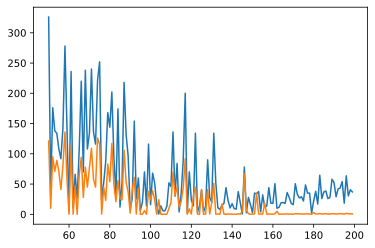

In [96]:
df["Ice cream"].plot()
df["Hot chocolate"].plot()

In [97]:
dfRoll = df.rolling(20, center = True).mean()

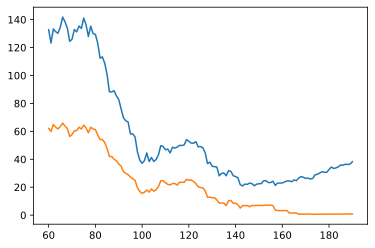

In [98]:
#df["Ice cream"].plot()
dfRoll["Ice cream"].plot()
dfRoll["Hot chocolate"].plot();

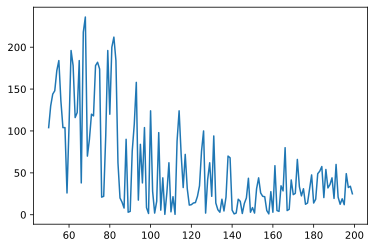

In [77]:
plt.plot(stocks, Costs["Ice cream"]);

#plt.savefig('stck.svg')

In [16]:
## Empirical Argmin of stock 
stocks[ np.argmin(Costs["Ice cream"]) ]

133

In [31]:
CF = c_I/(c_I + s_I)
CF

0.8

In [8]:
Pcdf = poisson.cdf(stocks, mu = 100 ) # mu Run_time/mean

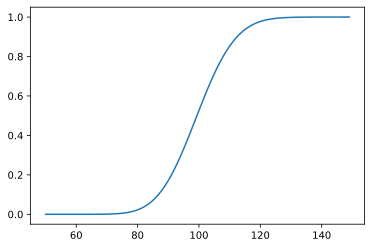

In [9]:
plt.plot(stocks,Pcdf);

In [176]:
ind = np.searchsorted(Pcdf,CF)
ind

58

In [177]:
xstar = stocks[ind]
xstar ## Theoretical

108